In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

# Loading Data

In [2]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Tue Jan  5 13:27:07 2021
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Tue Jan  5 13:27:07 2021
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


# Cleaning Data

In [3]:
count_nan = len(original_training_data) - original_training_data.count()
print(count_nan)
original_training_data["subject"].fillna(" ", inplace=True)
count_nan = len(original_training_data) - original_training_data.count()
print(count_nan)

id         0
subject    6
email      0
spam       0
dtype: int64
id         0
subject    0
email      0
spam       0
dtype: int64


In [4]:
first_ham = original_training_data['email'][original_training_data["spam"] == 0].iloc[0]
first_spam = original_training_data['email'][original_training_data["spam"] == 1].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



# Train Validation Split

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Feature Engineering

In [6]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = np.empty([texts.size, len(words)])
    
    for i in range(texts.size):
        for j in range(len(words)):
            indicator_array[i][j] = pd.Series(texts.iloc[i]).str.contains(words[j]).sum()
            
    return indicator_array.astype(int)

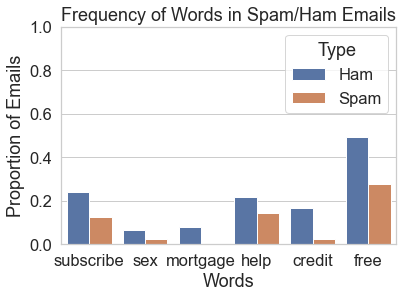

In [7]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words = ["subscribe", "sex", "mortgage", "help", "credit", "free"]

ham_flags = words_in_texts(words, train["email"][train["spam"]==0])
spam_flags = words_in_texts(words, train["email"][train["spam"]==1])

df = pd.DataFrame()
df["Proportion of Emails"] = [(sum(col))/(1.0 * len(col)) for col in spam_flags.T] + [(sum(col))/(1.0 * len(col)) for col in ham_flags.T]
df["Type"] = pd.Series(["Ham", "Ham", "Ham", "Ham", "Ham", "Ham", "Spam", "Spam", "Spam", "Spam", "Spam", "Spam"])
df["Words"] =  pd.Series(words+words)
sns.barplot(data=df, x="Words", y="Proportion of Emails", hue="Type")

plt.title("Frequency of Words in Spam/Ham Emails")
plt.ylim(0, 1.0);

/Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


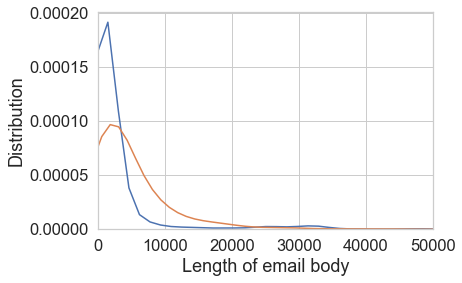

In [8]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

ham_flags = train["email"][train["spam"]==0].str.len()
spam_flags = train["email"][train["spam"]==1].str.len()

sns.distplot(ham_flags, kde_kws={"label": "Ham"}, hist=False)
sns.distplot(spam_flags, kde_kws={"label": "Spam"}, hist=False)

plt.xlabel("Length of email body")
plt.ylabel("Distribution")
plt.xlim(0, 50000);

In [9]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = train["spam"]

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [11]:
train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [12]:
Y_train_hat = model.predict(X_train)

mod_Y_train = np.array(Y_train)
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(mod_Y_train)):
    if Y_train_hat[i] == 1 and mod_Y_train[i] == 1:
        tp += 1
    elif Y_train_hat[i] == 1 and mod_Y_train[i] == 0:
        fp += 1
    elif Y_train_hat[i] == 0 and mod_Y_train[i] == 1:
        fn += 1   
    elif Y_train_hat[i] == 0 and mod_Y_train[i] == 0:
        tn += 1 
        
logistic_predictor_precision = tp / (tp + fp)
logistic_predictor_recall = tp / (tp + fn)
logistic_predictor_far = fp / (fp + tn)
logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far, fp, fn

(0.6422287390029325, 0.11418143899895725, 0.021805183199285077, 122, 1699)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

!pip install --upgrade nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import heapq

original_training_data = pd.read_csv('data/train.csv')
original_training_data['subject_and_email'] = original_training_data['subject'].combine_first(original_training_data['email'])

X = original_training_data["subject_and_email"]
stop = stopwords.words("english")
X_tokens = X.apply(word_tokenize)
X_without_sw = [word for word in X_tokens if not word in stop]

wordfreq = {}
for tokens in X_without_sw:
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
            
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

sentence_vectors = []
for tokens in X_without_sw:
    temp = []
    for token in most_freq:
        if token in tokens:
            temp.append(1)
        else:
            temp.append(0)
    sentence_vectors.append(temp)
        
X_without_sw = np.array(sentence_vectors)
#vec = CountVectorizer(stop_words=stop)
#X = vec.fit_transform(X).toarray()
Y = original_training_data["spam"]
X_train, X_test, Y_train, Y_test = train_test_split(X_without_sw, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
X_train, Y_train

Requirement already up-to-date: nltk in /Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages (3.5)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hideakiyoshida/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hideakiyoshida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 2181    0
 5515    0
 1153    1
 198     0
 6844    0
        ..
 5734    0
 5191    1
 5390    0
 860     0
 7270    0
 Name: spam, Length: 6678, dtype: int64)

In [14]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
params = {
    "C":[0.01, 0.05, 0.1, 0.25, 0.5, 0.9, 1, 10],
    "dual": [False],
    "fit_intercept":[True,False],
    "max_iter":[10, 25],
    "penalty":["l2"]
}
cv = GridSearchCV(model, params)
cv.fit(X_train, Y_train)
cv.best_params_,cv.best_score_

/Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

({'C': 1,
  'dual': False,
  'fit_intercept': True,
  'max_iter': 25,
  'penalty': 'l2'},
 0.8736161385094979)

In [15]:
model = LogisticRegression(C=1, dual=False, fit_intercept=True, max_iter=25, penalty='l2')
model.fit(X_train, Y_train)
accuracy_score(model.predict(X_test), Y_test)

/Users/hideakiyoshida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.881437125748503